In [1]:
%reload_ext autoreload
%autoreload 2

import os, psutil

os.environ['NUMEXPR_MAX_THREADS'] = '20'
os.environ['NUMBA_DEBUGINFO'] = '0'

from alphadia.extraction import processlogger
processlogger.init_logging()
import logging

logger = logging.getLogger()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neptune.new as neptune

#from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
#from alphabase.spectral_library.reader import LibraryReaderBase

from alphadia.extraction.data import TimsTOFDIA
from alphadia.extraction.planning import Plan, Workflow
from alphadia.extraction.calibration import RunCalibration
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import fdr_correction, MS2ExtractionWorkflow
import alphadia.extraction.utils as utils
yaml_file = 'config.yaml'

raw_files = ['/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_03_02_MCT_scp_hela/20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_AID8_02_S4-E9_1_645.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A1_1_449.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A2_1_453.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A3_1_457.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A4_1_464.d'

             ]

output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs'

try:
    neptune_token = os.environ['NEPTUNE_TOKEN']
except KeyError:
    logger.error('NEPTUNE_TOKEN environtment variable not set')


0:00:02.996257  WARNING: WARNING: Temp mmap arrays are written to /var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/temp_mmap_n6i7cl8e. Cleanup of this folder is OS dependant, and might need to be triggered manually! Current space: 1,187,344,781,312
0:00:02.996736  WARNING: WARNING: No Bruker libraries are available for this operating system. Mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
0:00:02.996956  INFO: 


In [2]:
test_lib = SpecLibBase()
test_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/MSfragger_library_mod_noLossType_d0_d4_d8_shared_eg.hdf'
test_lib.load_hdf(test_lib_location, load_mod_seq=True)

test_lib.precursor_df = test_lib.precursor_df[test_lib.precursor_df['channel'] == 0]

In [3]:
plan = Plan(raw_files)
plan.from_spec_lib_base(test_lib)
#plan.run(output_location, keep_decoys=True, fdr=1.0)
for dia_data, precursors_flat, fragments_flat in plan.get_run_data():
    break

0:00:09.061017  PROGRESS:       _   _      _         ___ ___   _   
0:00:09.061863  PROGRESS:      /_\ | |_ __| |_  __ _|   \_ _| /_\  
0:00:09.062565  PROGRESS:     / _ \| | '_ \ ' \/ _` | |) | | / _ \ 
0:00:09.062998  PROGRESS:    /_/ \_\_| .__/_||_\__,_|___/___/_/ \_\
0:00:09.063452  PROGRESS:            |_|                            
0:00:09.064023  PROGRESS: 
0:00:09.064517  INFO: loading default config from /Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/../../misc/config/default.yaml
0:00:09.070957  PROGRESS: version: 1.0.1
0:00:09.071396  PROGRESS: hostname: Georgs-MacBook-Pro.local
0:00:09.071656  PROGRESS: date: 2023-03-15 18:20:04
0:00:12.894499  INFO: renaming precursor_columns columns
0:00:12.895385  INFO: renaming fragment_columns columns
0:00:12.895776  INFO: ========= Library Stats =========
0:00:12.896004  INFO: Number of precursors: 91,732
0:00:12.911571  INFO: 	thereof targets:45,867
0:00:12.911992  INFO: 	thereof decoys: 45,865
0:00:12.913167  INFO:

In [4]:
jit_data = dia_data.jitclass(transpose=True)

0:02:24.119089  INFO: Duty cycle consists of 9 frames, 0.96 seconds cycle time
0:02:24.122283  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:02:24.127031  INFO: Expected peak length in RT is 10.00 seconds, sigma is 5.21
0:02:24.134959  INFO: Expected peak length in mobility is 0.03 1/K_0, sigma is 23.20
0:02:24.206854  INFO: starting candidate selection
  0%|          | 0/10 [00:00<?, ?it/s]

[1 0]


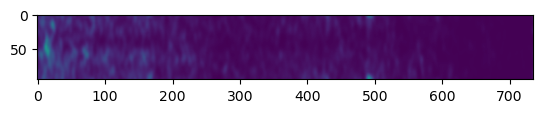

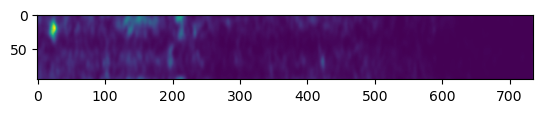

 10%|█         | 1/10 [00:00<00:07,  1.19it/s]

[0 1]


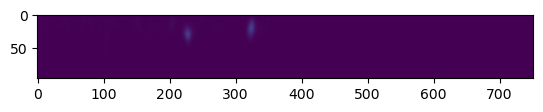

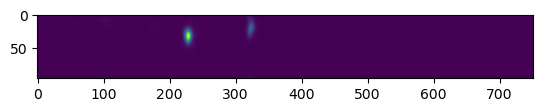

 20%|██        | 2/10 [00:01<00:05,  1.41it/s]

[0 1]


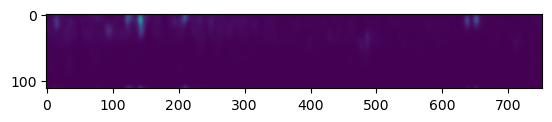

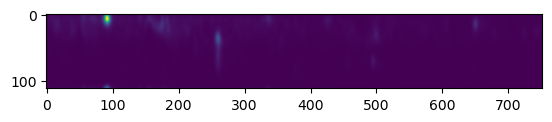

 30%|███       | 3/10 [00:02<00:04,  1.48it/s]

[1 0]


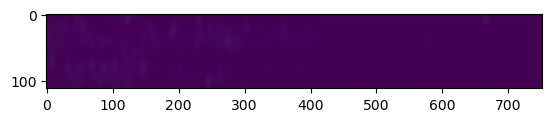

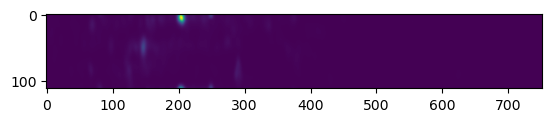

 40%|████      | 4/10 [00:02<00:03,  1.66it/s]

[1 0]


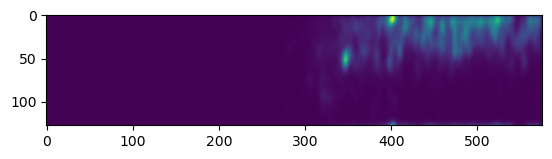

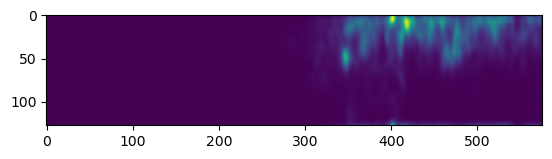

 50%|█████     | 5/10 [00:03<00:02,  1.72it/s]

[0 1]


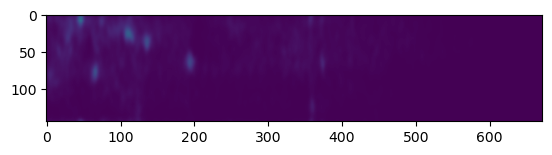

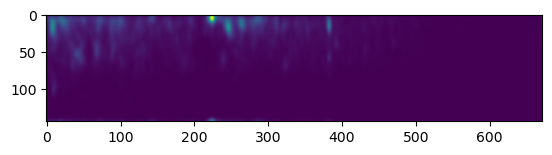

 60%|██████    | 6/10 [00:03<00:02,  1.81it/s]

[1 0]


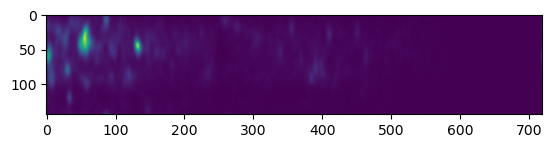

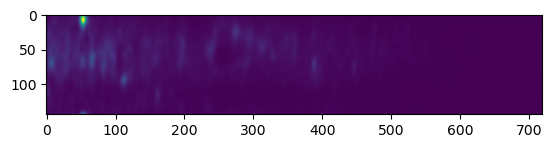

 70%|███████   | 7/10 [00:04<00:01,  1.82it/s]

[1 0]


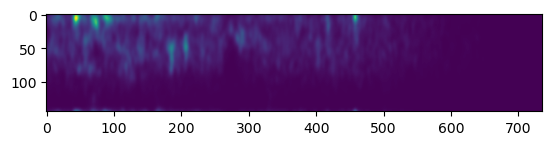

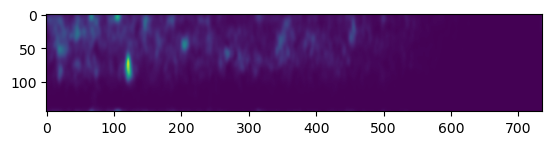

 80%|████████  | 8/10 [00:04<00:01,  1.94it/s]

[1]


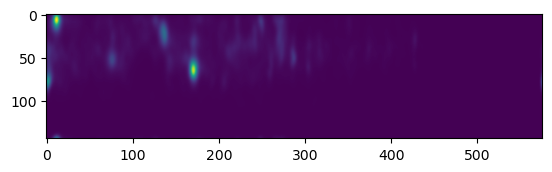

[0 1]


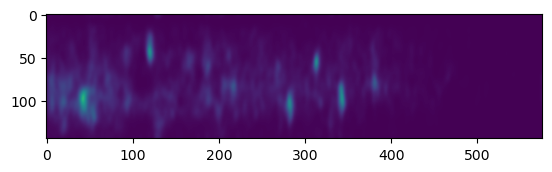

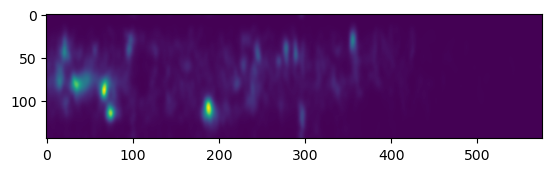

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


In [8]:
from alphadia.extraction import hybridselection

precursors_flat = precursors_flat.sort_values('rt_library')


selection = hybridselection.HybridCandidateSelection(
    jit_data,
    precursors_flat[:3000],
    fragments_flat,
    rt_tolerance=360,
    mz_tolerance=120,
    mobility_tolerance=0.05,
    candidate_count=3,
    thread_count=12,
    debug=True,
    )
egs = selection()

In [9]:
from alphadia.extraction.numba import fragments, numeric
from alphadia.extraction.candidateselection import peak_boundaries_symmetric, GaussianFilter
gaussian_filter = GaussianFilter(
    dia_data
)
kernel = gaussian_filter.get_kernel()

0:03:47.128858  INFO: Duty cycle consists of 9 frames, 0.96 seconds cycle time
0:03:47.129509  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
0:03:47.129937  INFO: Expected peak length in RT is 10.00 seconds, sigma is 5.21
0:03:47.130223  INFO: Expected peak length in mobility is 0.03 1/K_0, sigma is 23.20


In [10]:
import numba as nb
@nb.njit
def build_score(
    dense_precursors,
    dense_fragments,
    precursor_mz,
    precursor_intensity,
    fragment_mz,
    fragment_intensity,
    kernel
    ):

    smooth_precursor = numeric.fourier_a1(dense_precursors[0,:,:,:,:], kernel)
    smooth_precursor = smooth_precursor.sum(axis=1)
    smooth_fragment = numeric.fourier_a1(dense_fragments[0,:,:,:,:], kernel)
    smooth_fragment = smooth_fragment.sum(axis=1)
    
    n_scores = precursor_intensity.shape[0]

    score = np.zeros(
        (
            n_scores, 
            dense_precursors.shape[3],
            dense_precursors.shape[4]
        )
    )
    for score_idx in range(n_scores):

        fragment_mask = fragment_intensity[score_idx] > 0
        precursor_mask = precursor_intensity[score_idx] > 0

        current_smooth_fragment = smooth_fragment[fragment_mask]
        current_smooth_precursor = smooth_precursor[precursor_mask]
        current_fragment_intensity = fragment_intensity[score_idx][fragment_mask]
        current_precursor_intensity = precursor_intensity[score_idx][precursor_mask]

        precursor_kernel = current_precursor_intensity.reshape(-1, 1, 1)

        precursor_dot = np.sum(current_smooth_precursor * precursor_kernel, axis=0)
        precursor_dot_mean = np.mean(precursor_dot)
        precursor_norm = precursor_dot/(precursor_dot_mean+0.001)
        
        fragment_kernel = current_fragment_intensity.reshape(-1, 1, 1)
        fragment_dot = np.sum(current_smooth_fragment * fragment_kernel, axis=0)
        fragment_dot_mean = np.mean(fragment_dot)
        fragment_norm = fragment_dot/(fragment_dot_mean+0.001)

        score[score_idx] = precursor_norm * fragment_norm

    return score




In [12]:
print(eg.dense_precursors.shape)

(0, 0, 0, 0, 0)


In [14]:
for eg in egs:

    if eg.dense_precursors.shape[-1] > 10:
        s = build_score(
            eg.dense_precursors, 
            eg.dense_fragments, 
            eg.precursor_mz,
            eg.precursor_intensity,
            eg.fragment_mz,
            eg.fragment_intensity,
            kernel
        )

In [33]:
egs[0].fragment_intensity
egs[0].decoy

array([1, 0], dtype=uint8)

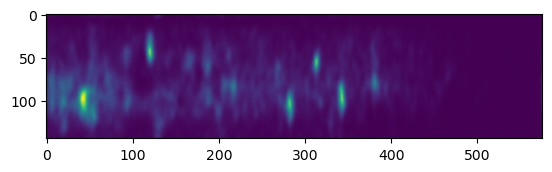

In [19]:
plt.imshow(s[0])

In [6]:
from alphadia.extraction.numba import numeric
from alphadia.extraction.numba import fragments
import numba as nb
from tqdm import tqdm

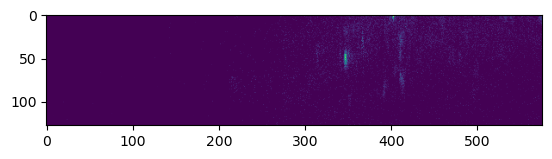

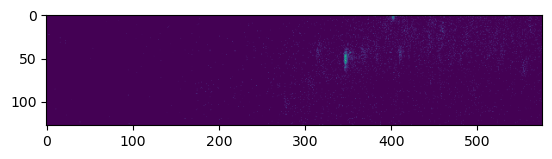

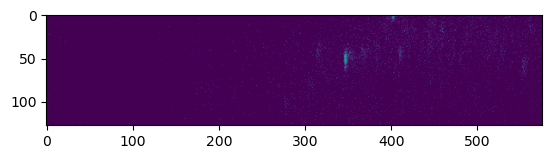

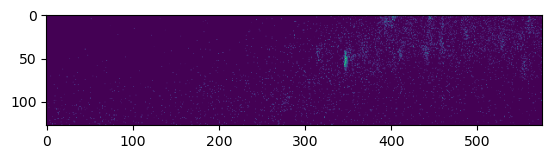

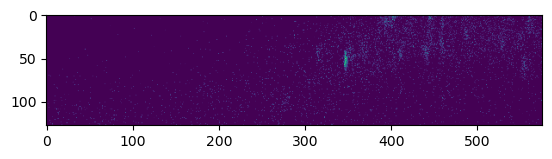

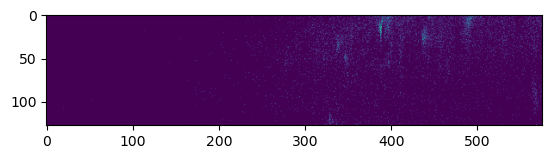

In [103]:
#%%timeit

tof_slice, values, push_indices, absolute_precursor_index, tof_indices = filter_push(
    precursor_tof_limits,
    jit_data.push_indices,
    jit_data.tof_indptr, 
    push_query,
    _absolute_precursor_index
)

precursor_index = np.unique(absolute_precursor_index)
n_precursor_indices = len(precursor_index)
precursor_index_reverse = np.zeros(np.max(precursor_index)+1, dtype=np.int64)
precursor_index_reverse[precursor_index] = np.arange(len(precursor_index))

relative_precursor_index = precursor_index_reverse[absolute_precursor_index]

frame_indices = push_indices // jit_data.scan_max_index
scan_indices = push_indices % jit_data.scan_max_index
precursor_cycle_indices = (frame_indices-jit_data.zeroth_frame)//jit_data.cycle.shape[1]

# cycle values
precursor_cycle_start = int(eg.frame_limits[0,0]-jit_data.zeroth_frame)//jit_data.cycle.shape[1]
precursor_cycle_stop = int(eg.frame_limits[0,1]-jit_data.zeroth_frame)//jit_data.cycle.shape[1]
precursor_cycle_len = precursor_cycle_stop - precursor_cycle_start

# scan valuesa
mobility_start = eg.scan_limits[0,0]
mobility_stop = eg.scan_limits[0,1]
mobility_len = mobility_stop - mobility_start

#tof_indices = jit_data.tof_indices[values]
mz_values = jit_data.mz_values[tof_indices]

intensities = jit_data.intensity_values_t[values]

# number of channels: intensity, mz
n_channels = 2

n_tof_slices = len(precursor_tof_limits)

dense_output = np.zeros(
    (
        n_channels, 
        n_tof_slices,
        n_precursor_indices,
        mobility_len,
        precursor_cycle_len
    ), 
    dtype=np.float64
)

# create dense intensities
for i, (_tof_slice, intensity, mz, p_slice) in enumerate(zip(tof_slice, intensities, mz_values, relative_precursor_index)):
    mobility = scan_indices[i]-mobility_start
    precursor_cycle = precursor_cycle_indices[i]-precursor_cycle_start
    dense_output[0, _tof_slice, p_slice ,mobility, precursor_cycle] += intensity

for i in range(n_tof_slices):
    plt.imshow(dense_output[0,i,0,:,:])
    plt.show()


In [18]:
values.shape

(4416,)

In [22]:
np.unique(absolute_precursor_index)

array([0])

In [20]:
push_indices.shape

(4416,)

In [21]:
tof_slice.shape

(4416,)

In [30]:
nb.typeof(jit_data.push_indices)

array(uint32, 1d, C)

In [32]:
push_query.shape

(84224,)

In [33]:
push_indices.shape

(4686,)

In [40]:
absolute_precursor_index.shape

(70656,)

In [51]:
push_indices, absolute_precursor_cycle = get_push_indices(
        jit_data,
        eg.frame_limits,
        eg.scan_limits,
        fragment_cycle_mask
    )

In [54]:
push_indices.shape

(8192,)

In [52]:
np.unique(absolute_precursor_cycle)

array([1])

In [44]:
np.unique(source_indices)

array([0, 1, 2])

In [45]:
np.unique(absolute_precursor_index)

array([0, 1])

In [46]:
quadrupole_mz

array([[403.70510864, 404.20678711],
       [394.70230103, 395.20397949]])

In [27]:
push_query.shape

(4096,)

In [ ]:
cycle_limits = eg.frame_limits//jit_data.cycle.shape[1]

In [ ]:
@nb.njit

def get_optimized_push_indices(
        jit_data,
        cycle_limits,
        scan_limits,
        score_group_cycle_mask,
        precursor_cycle_mask,
    ):

    for cycle_index in range(cycle_limits[0,0], cycle_limits[0,1]):
        cycle_start_index = cycle_index * jit_data.cycle.shape[1] * jit_data.scan_max_index

        
get_optimized_push_indices(
        jit_data,
        cycle_limits,
        eg.scan_limits,
        score_group_cycle_mask,
        precursor_cycle_mask,
    )

In [ ]:
cycle_limits

In [ ]:



             
push_indices, score_group, absolute_precursor_cycle = get_push_indices(
    jit_data,
    eg.frame_limits,
    eg.scan_limits,
    score_group_cycle_mask,
    precursor_cycle_mask,
)


In [ ]:
%timeit get_push_indices(jit_data, eg.frame_limits, eg.scan_limits, score_group_cycle_mask, precursor_cycle_mask)

In [ ]:
@nb.njit
def unique(a):
    return np.array(list(set(a)))

%timeit unique(absolute_precursor_cycle)

In [ ]:
precursor_mz

In [ ]:
print()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
pos = ax.imshow(fragments_dense[1,1,0,:,:],cmap='RdBu_r')
fig.colorbar(pos, ax=ax)
plt.show()

In [ ]:
%%timeit
get_dense_hybrid(
    jit_data, 
    eg.frame_limits,
    eg.scan_limits,
    precursor_mz,
    120,
    fragment_mz,
    120,
    quadrupole_mz
    )

In [ ]:
fragment_mz

In [ ]:
%timeit get_dense_hybrid( jit_data, eg.frame_limits, eg.scan_limits, precursor_mz, fragment_mz, quadrupole_mz)

In [ ]:
import numba as nb

os.environ['DEBUG'] = 'True'

from alphadia.extraction.hybridselection import HybridElutionGroup, HybridElutionGroupContainer

def assemble_elution_groups(
        precursors_flat,
        rt_column='rt_library',
        mobility_column='mobility_library',
        precursor_mz_column='mz_library'
        ):
    
    """
    Assemble elution groups from precursor library.

    Parameters
    ----------

    precursors_flat : pandas.DataFrame
        Precursor library.

    rt_column : str
        Column name of the retention time values.

    mobility_column : str
        Column name of the mobility values.

    precursor_mz_column : str
        Column name of the precursor m/z values.

    Returns
    -------
    HybridElutionGroupContainer
        Numba jitclass with list of elution groups.
    """
    
    if len(precursors_flat) == 0:
        return

    available_isotopes = utils.get_isotope_columns(precursors_flat.columns)
    available_isotope_columns = [f'i_{i}' for i in available_isotopes]

    precursors_sorted = precursors_flat.sort_values('elution_group_idx').copy()

    @nb.njit(debug=True)
    def assemble_njit(
        elution_group_idx,
        precursor_idx,
        channel,
        flat_frag_start_stop_idx,
        rt_values,
        mobility_values,
        charge,
        decoy,
        precursor_mz,
        isotope_intensity
    ):
        elution_group = elution_group_idx[0]
        elution_group_start = 0
        elution_group_stop = 0

        eg_list = []
        
        while elution_group_stop < len(elution_group_idx)-1:
            
            elution_group_stop += 1

            if elution_group_idx[elution_group_stop] != elution_group:
                    
                eg_list.append(HybridElutionGroup(    
                    elution_group,
                    precursor_idx[elution_group_start:elution_group_stop],
                    channel[elution_group_start:elution_group_stop],
                    flat_frag_start_stop_idx[elution_group_start:elution_group_stop],
                    rt_values[elution_group_start],
                    mobility_values[elution_group_start],
                    charge[elution_group_start],
                    decoy[elution_group_start:elution_group_stop],
                    precursor_mz[elution_group_start:elution_group_stop],
                    isotope_intensity[elution_group_start:elution_group_stop]
                ))

                elution_group_start = elution_group_stop
                elution_group = elution_group_idx[elution_group_start]
                
        egs = nb.typed.List(eg_list)
        return HybridElutionGroupContainer(egs)

    return assemble_njit(
        precursors_sorted['elution_group_idx'].values.astype(np.uint32),
        precursors_sorted['precursor_idx'].values.astype(np.uint32),
        precursors_sorted['channel'].values.astype(np.uint32),
        precursors_sorted[['flat_frag_start_idx','flat_frag_stop_idx']].values.copy().astype(np.uint32),
        precursors_sorted[rt_column].values.astype(np.float64),
        precursors_sorted[mobility_column].values.astype(np.float64),
        precursors_sorted['charge'].values.astype(np.uint8),
        precursors_sorted['decoy'].values.astype(np.uint8),
        precursors_sorted[precursor_mz_column].values.astype(np.float64),
        precursors_sorted[available_isotope_columns].values.copy().astype(np.float32),
    )
    

In [ ]:
assemble_elution_groups(precursors_flat)

In [ ]:
%timeit assemble_elution_groups(precursors_flat)

In [ ]:
from alphadia.extraction import candidateselection

gaussian = candidateselection.GaussianFilter(dia_data)
kernel = gaussian.get_kernel()

In [ ]:
plt.imshow(kernel)

In [ ]:
kernel[:,10:].shape

In [ ]:
p = dense_precursors[0,0,:,:32,:64]
p.shape

In [ ]:
x = np.tile(p, (10,1,1,1))

In [ ]:
x.shape

In [ ]:
%timeit smooth = fourier_a1(x, kernel)

In [ ]:
plt.imshow(p[0])

In [ ]:
plt.imshow(smooth[0])

In [ ]:
plt.imshow(roll(smooth[0,0],-10,-10))

In [ ]:
import numba as nb
import numpy as np

@nb.njit
def jit_fft(x):
    return np.fft.fft(x)

a = np.array([2, 7, 1, 8, 2, 8, 1, 8])
jit_fft(a)

In [ ]:
from alphadia.extraction import quadrupole, scoring, features
q = quadrupole.SimpleQuadrupole(dia_data.cycle)

In [ ]:
from alphadia.extraction import scoring

extraction = scoring.MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    candidates,
    q,
    precursor_mz_tolerance=30,
    fragment_mz_tolerance=30
)

feature_df, fragment_df = extraction()

In [ ]:
df = scoring.fdr_correction(feature_df)

In [ ]:
df = scoring.fdr_correction(df)